In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
pt = 1./72.27 
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 20, fmax = 2000, n_freq = 4000.)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


/opt/anaconda3/envs/geotgr/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/geotgr/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))



data_150914 = np.array(data[1])
data_150914[0] = 3
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390/10

idx = '150914'
# idx = '170817'
if idx=='150914':
    data_150914 = np.array(data[1])
    data_150914[0] = 30
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390
    dat = jnp.array(data_150914)
elif idx=='170817':
    data_150914 = np.array(data[1])
    data_150914[0] = 1.2
    q  = 0.73
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390/10
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.
x['s1_x'] = 0.

prec_pe = True
# prec_pe = False
if prec_pe:
    i = None
else:
    i = -2
hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()[:i]
paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
freqs = obj.freqs.copy()
dets = ["H1", "L1", "V1"]

In [3]:


from scipy.sparse.linalg import eigsh
r = np.loadtxt("data/cache_delta_psi_3rd.txt")
f_n_orig = np.loadtxt("data/cache_freq_3rd.txt")
fend = f_n_orig[-1]


μ = np.mean(r, axis=0)
σ = np.var(r, axis=0)**(1/2)
R = r - μ
temp = np.einsum('ij,ik->jk', R, R)  # this computes the outer product of ΔΨ(f)*ΔΨ(f') as 2d array and sums it.
cov = temp/len(r[:,0]) # the two point function is the divided by the number of averages.

nλ = 1
λ, v  = eigsh(cov, nλ)
v = np.sign(v[-1,:])* v


In [4]:

def get_dpsi_nvnl(freqs, p):
    Mc = p["M_c"]
    eta = p["eta"]
    dPsi = np.sqrt(λ) * v[:,0]
    dPsi = dPsi- dPsi[-1]

    M = pycbc.conversions.mtotal_from_mchirp_eta(Mc,eta)*Ms
    
    # intp = interp.interp1d(f_n_orig, dPsi, kind='linear', fill_value = (0, dPsi[-1]), bounds_error=False)
    # dPsi = intp(freqs*M)
    dPsi = np.interp(freqs*M, f_n_orig, dPsi, left = 0, right = dPsi[-1])
    return dPsi


def make_Dh_nvnl_norm(x, snr=1):
    norm = get_dpsi_nvnl(np.array([20]), x) - get_dpsi_nvnl(np.array([6000]), x)
    dphik_guess = 1/norm
    dpsi = dphik_guess* get_dpsi_nvnl(freqs, x)
    h = obj.get_h_gr(x)
    Dh={}
    for d in dets:
        Dh[d] = 1j*dpsi*h[d]
    norm = np.sum([lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets])**(1/2)
    for d in dets:
        Dh[d] = Dh[d]/norm
    return Dh

def compute_Dh_nvnl_perp(dh, x, param, cov):
    Dh = make_Dh_nvnl_norm(x)
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in param), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if True:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh



In [5]:
def make_Dh_ppe(kinj, dphik, x, norm_dh = False):
    Dh = {}
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    for d in dets:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    if norm_dh:
        normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
        norm = np.sum(normarr)**(1/2)
        dpsi_inj = dpsi_inj/norm
        for d in dets:
            Dh[d] = Dh[d]/norm
    return Dh

def make_Dh_ppe_norm(kinj, x, snr=1):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik_guess = 1/norm
    Dh = make_Dh_ppe(kinj, dphik_guess, x, norm_dh = True)
    for d in dets:
        Dh[d] = Dh[d]/snr
    return Dh

def compute_Dh_ppek_perp(k, dh, x, param, cov):
    Dh = make_Dh_ppe_norm(k, x)
    if k==5:
        for d in dets:
            Dh[d] = Dh[d]*0
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in param), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if k!=5:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh



dh = obj.get_dh_gr(x)
fi = obj.compute_fisher_raw(dhgr, x, paramgr)
# kk = np.array(list(obj.k2str.keys()))
cov = jnp.linalg.inv(fi)
res = {}
resDh = {}
kk = np.array(list(obj.k2str.keys()))
for k in kk:
    dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
    res[obj.k2str[k]] = dhperp
    resDh[obj.k2str[k]] = Dh
# res = compute_Dh_ppek_perp(kk[0], dhgr, x, paramgr, cov)
dhperp_nvnl, Dh_nvnl = compute_Dh_nvnl_perp(dhgr, x, paramgr, cov)

In [6]:
# len(kk)

kkvals = kk[kk != 5]  # This removes 5 from the array

ff = np.zeros((len(kkvals),len(kkvals)))
for i in range(len(kkvals)):
    for j in range(len(kkvals)):
        dh_1 = res[obj.k2str[kkvals[i]]]
        dh_2 = res[obj.k2str[kkvals[j]]]

        ff[i,j] = np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])

/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_17156/186989074.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  ff[i,j] = np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])


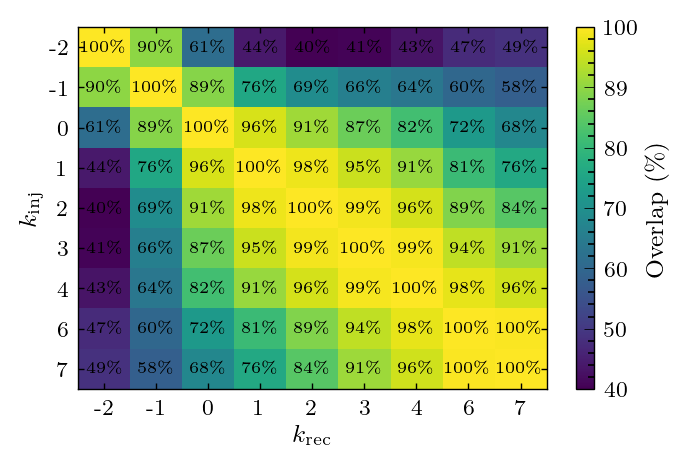

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter



fig = plt.figure(figsize = (my_width, my_width/golden),dpi=100)
ax = fig.gca()

mmarr = np.abs(ff)

# Ensure values are between 0 and 1 for percentage representation
mmarr_safe = np.clip(mmarr, 0, 1)

# Define levels for percentage scale (0% to 100%)
levels = np.linspace(0.4, 1, 7)
normbar = mcolors.Normalize(vmin=0.4, vmax=1)

# Plot using percentage scale
plt.imshow(mmarr_safe, cmap='viridis', interpolation='nearest', aspect='auto', norm=normbar)

# Add discrete color bar
cbar = plt.colorbar(ticks=levels)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x * 100)}"))
cbar.set_label(r'Overlap (\%)')

# Label axes
plt.xlabel(r"$k_{\mathrm{rec}}$")
plt.ylabel(r"$k_{\mathrm{inj}}$")

# Annotate each cell with percentage values
for i in range(len(kkvals)):
    for j in range(len(kkvals)):
        text = fr"{mmarr_safe[i, j] * 100:.0f}\%"  # Convert to percentage
        ax.text(j, i, text, ha="center", va="center", color="k", fontsize=6, weight="bold")

# Set tick labels
plt.xticks(ticks=np.arange(len(kkvals)), labels=kkvals)
plt.yticks(ticks=np.arange(len(kkvals)), labels=kkvals)

# Adjust tick parameters
ax.tick_params(which='minor', bottom=False, left=False, top=False, right=False)
ax.tick_params(axis='x', length=2, width=0.5)  # Make x-tick marks smaller
ax.tick_params(axis='y', length=2, width=0.5)  # Make y-tick marks smaller

# plt.savefig("ff-pn-tests-spin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-spin-bns.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin-bns.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [8]:
dh_1 = res[obj.k2str[kk[1]]]
dh_2 = res[obj.k2str[kk[3]]]

np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])


np.complex128(0.7583088257942158+0j)

In [9]:
def compute_H_svd(all_dets=True,perp=True):
    rows = []
    for key in obj.str2k:
        if obj.str2k[key] !=5:
            if perp:
                detectors = res[key]
            else:
                detectors = resDh[key]
            if all_dets:
                concatenated = np.concatenate([weight*detectors["H1"], weight*detectors["L1"], weight*detectors["V1"]])
            else:
                concatenated = np.concatenate([weight*detectors["H1"]])
            rows.append(concatenated)
    return rows

df = np.diff(obj.freqs)
delta_f = np.empty_like(obj.freqs, dtype=float)
delta_f[1:-1] = (df[:-1] + df[1:]) / 2.0
delta_f[0] = df[0]
delta_f[-1] = df[-1]
weight = np.sqrt(4*delta_f/obj.psdO3)

Hperp = compute_H_svd()
Hperpsingle = compute_H_svd(all_dets=False)
HDh = compute_H_svd(perp=False)




# U, s, Vh = np.linalg.svd(Hperp, full_matrices=False)

# prints cov
# ii = 0
# for k in obj.k2str:
#     U, n2, Vh = np.linalg.svd(Hperp[ii:ii+1], full_matrices=False)
#     U, n1, Vh = np.linalg.svd(HDh[ii:ii+1], full_matrices=False)
#     print(n1[0])
#     print(f" {obj.k2str[k]} Dh: {np.real(n1[0]):.2e}, Dhperp: {np.real(n2[0]):.2e}")
#     ii += 1

# len(Hperp)

# singnorm 

(20.0, 250.0)

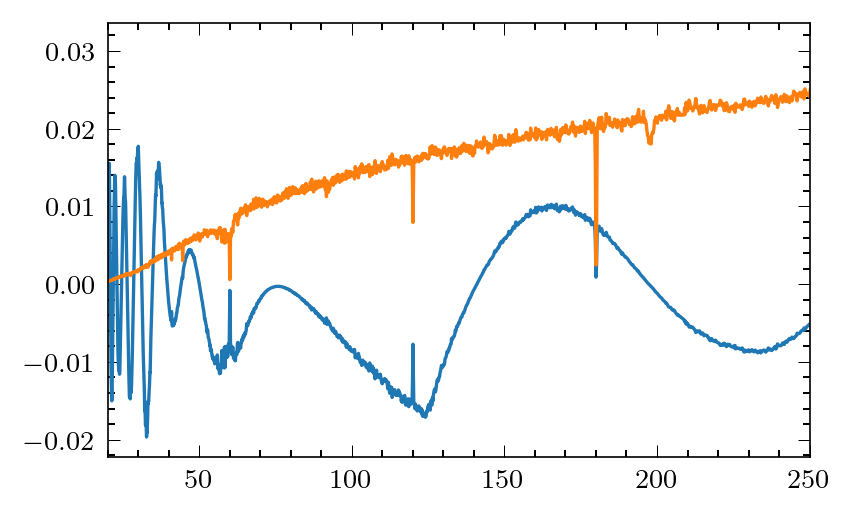

In [10]:
def build_real_matrix(H):
    """
    Given a complex matrix H of shape (Nfreq, A),
    return a real matrix M of shape (2*Nfreq, A),
    whose rows are [ Re(H);  Im(H) ].
    """
    Nfreq, A = H.shape
    
    # Allocate a real matrix of twice as many rows
    M = np.zeros((2 * Nfreq, A), dtype=float)
    
    # First block: real parts
    M[:Nfreq, :] = H.real
    
    # Second block: imaginary parts
    M[Nfreq:, :] = H.imag
    
    return M

def real_svd_of_H(H):
    """
    Build real-stacked M from complex H, then perform real SVD on M.
    Returns (U, s, Vt) so that M = U diag(s) Vt,
    with U, Vt both real-valued.
    """
    M = build_real_matrix(H)           # shape: (2*Nfreq, A)
    U, s, Vt = np.linalg.svd(M, full_matrices=False)
    return U, s, Vt, M

H = np.array(Hperpsingle)
U, s, Vt, Hfull = real_svd_of_H(H)

ii = 1
v = 1/s[ii] * (Hfull.conj().T @ U[:,ii])
# s
plt.plot(obj.freqs, np.real(H[1,:]))
plt.plot(obj.freqs,weight/1e25)

plt.xlim(20, 250)
# plt.ylim(-0.2,0.2)
# plt.legend(loc=1)

In [11]:
H = np.array(Hperpsingle)



U, s, Vt = np.linalg.svd(H, full_matrices=False)

/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_17156/1957959631.py:34: RuntimeWarning: invalid value encountered in divide
  dpsi_svd = Vh[i] / weight / np.abs(hgr["H1"]) * s[i] /3


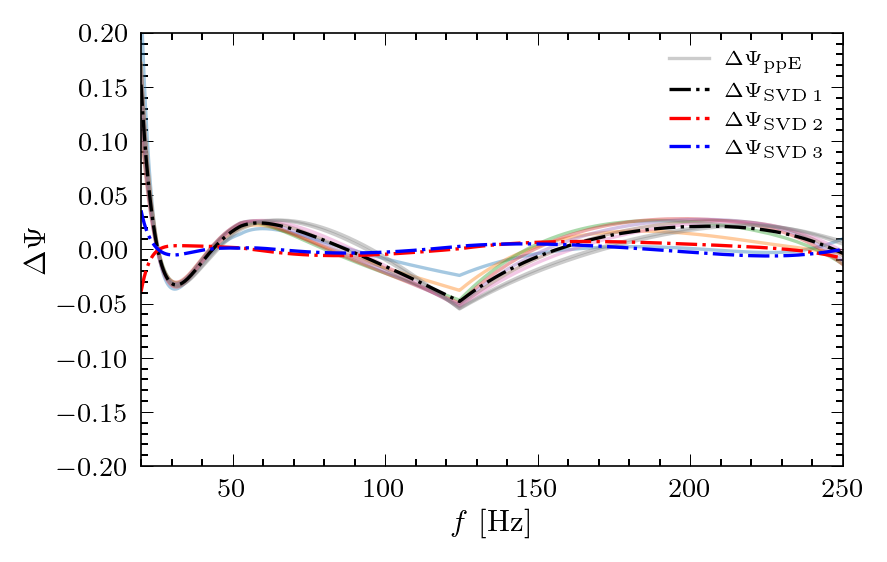

In [12]:
H = np.array(Hperpsingle)


Hp = np.imag(H * np.exp(-1j*np.angle(hgr["H1"])))
U, s, Vh = np.linalg.svd(Hp, full_matrices=False)

# ii = 0
# v = 1/s[ii] * (Hp.conj().T @ U[:,ii])

# # np.sum(np.abs(v)**2)
# v




# plt.ylim(-0.2,0.2)
# plt.legend(loc=1)


kkplt = [-2,-1,0,1, 2,3,4,6, 7]

for k in kkplt:
    # line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")

    if k!=7:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4)
    else:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4, c = "gray", label=r"$\Delta \Psi_\mathrm{ppE }$")

cc = ["k","r","b","gray","m"]
# norm = 1
norm = np.sqrt(obj.freqs)
for i in range(3):
    dpsi_svd = Vh[i] / weight / np.abs(hgr["H1"]) * s[i] /3
    # vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
    # ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
    plt.plot(obj.freqs, -dpsi_svd, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])

    

plt.xlim(20, 250)
plt.ylim(-0.2,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
plt.ylabel(r"$\Delta \Psi$") 
# plt.savefig("svd-plot-example.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

In [13]:
U[:,ii]

array([ 0.48506316, -0.02422309, -0.40443186, -0.41754426,
       -0.26996622, -0.08732594,  0.08487896,  0.35706183,
        0.45936202])

In [14]:
np.sum(np.abs(v)**2)

np.float64(1.0000000000000018)

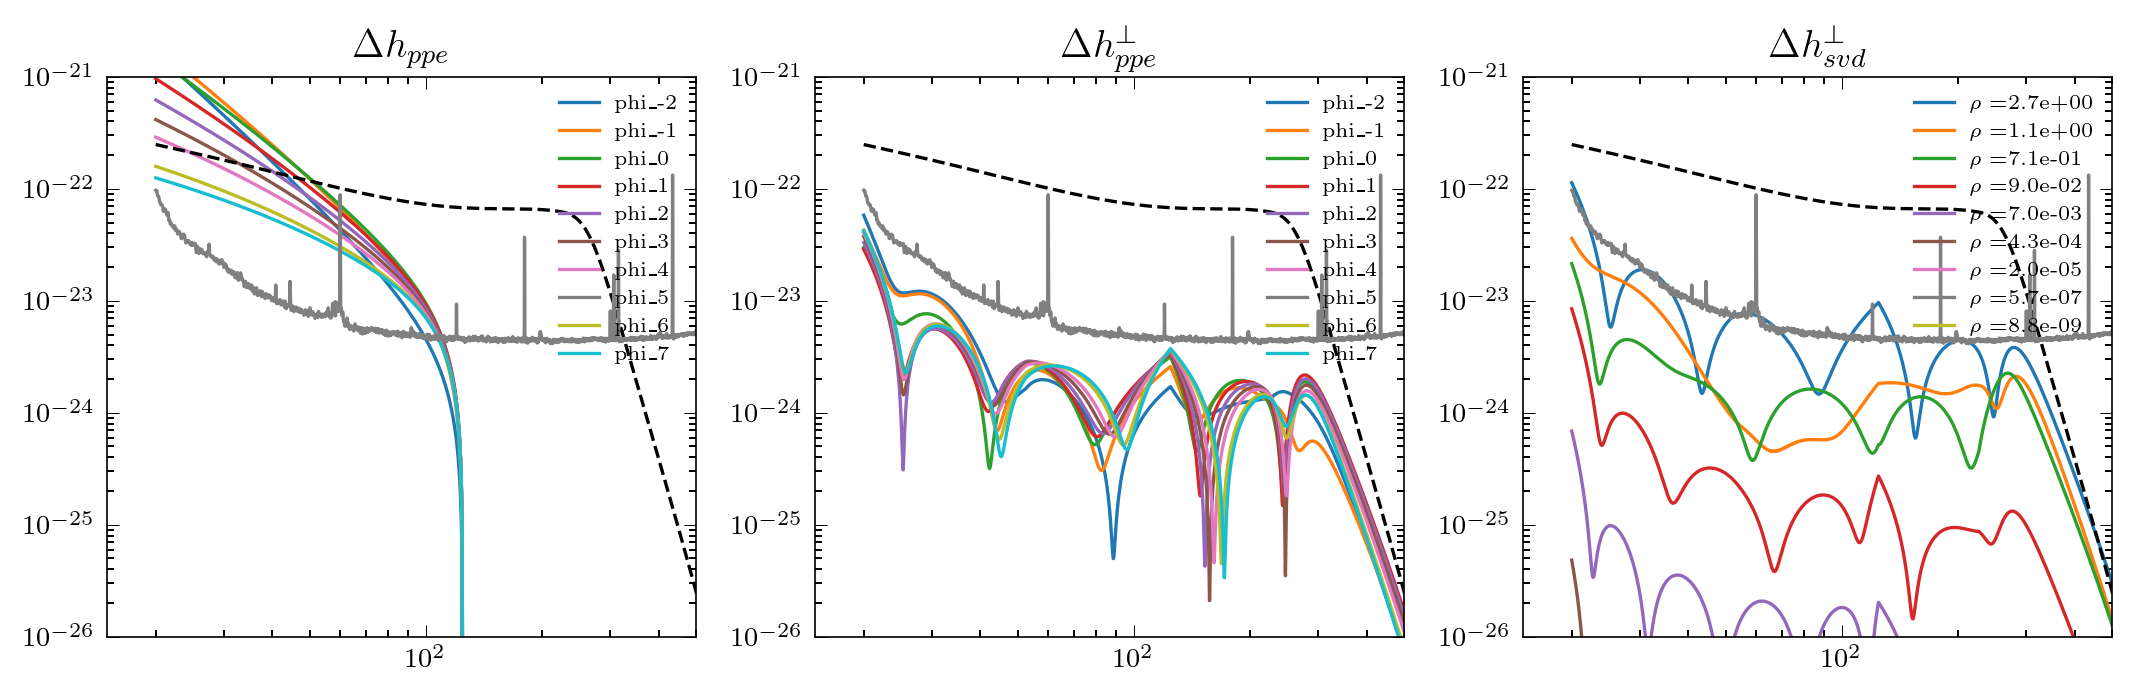

In [15]:
U, s, Vh = np.linalg.svd(Hperp, full_matrices=False)
normsvd = np.zeros(s.shape[0])
for j in range(s.shape[0]):
    normarr = np.zeros(3)
    for i in range(3):
        v = s[j]*Vh[j,i*4000:(i+1)*4000]/weight
        normarr[i] = np.real(lib.innprod(v, v, obj.psdO3, obj.freqs))
    normsvd[j] = np.sum(normarr)**(1/2)
    # print(np.sum(normarr)**(1/2))


fig, axs = plt.subplots(1, 3, figsize=(9, 3))

norm = 2*np.sqrt(obj.freqs)
for k in kk:
    axs[0].loglog(obj.freqs, norm*np.abs(resDh[obj.k2str[k]]["H1"]), label=obj.k2str[k])
axs[0].set_title(r"$\Delta h_{ppe}$")

for k in kk:
    axs[1].loglog(obj.freqs, norm*np.abs(res[obj.k2str[k]]["H1"]), label=obj.k2str[k])
axs[1].set_title(r"$\Delta h_{ppe}^\perp$")

for i in range(9):
    axs[2].loglog(obj.freqs, norm*np.abs(s[i] * Vh[i, :4000] / weight), label=rf"$\rho=${normsvd[i]:0.1e}")
axs[2].set_title(r"$\Delta h_{svd}^\perp$")

for i in range(3):
    axs[i].set_xlim(15, 500)
    axs[i].set_ylim(bottom=1e-26,top=1e-21)
    axs[i].legend(loc=1)
    axs[i].loglog(obj.freqs, norm*np.abs(obj.get_h_gr(x)["H1"]), ls="--", c="k")
    axs[i].loglog(obj.freqs, obj.psdO3**(1/2), c="grey")

plt.tight_layout()
plt.show()


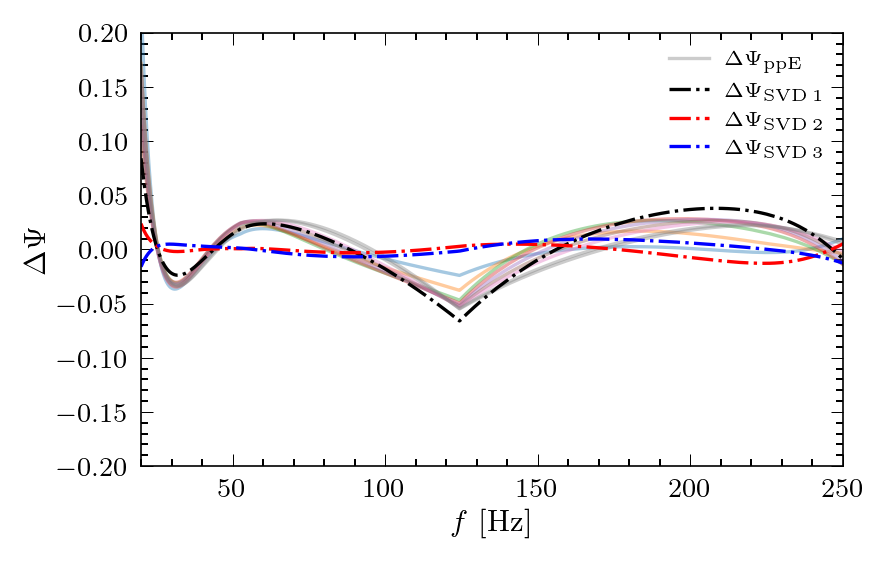

In [16]:
singnorm = np.real(np.sum(Hperpsingle*np.conj(Hperpsingle),axis=1))
U, s, Vh = np.linalg.svd(np.array(Hperpsingle), full_matrices=False)


kkplt = [-2,-1,0,1, 2,3,4,6, 7]

for k in kkplt:
    # line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")

    if k!=7:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4)
    else:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4, c = "gray", label=r"$\Delta \Psi_\mathrm{ppE }$")

cc = ["k","r","b","gray","m"]
# norm = 1
norm = np.sqrt(obj.freqs)
for i in range(3):
    vals = norm/9/np.sum(singnorm) * s[i] * Vh[i, :]/ weight / hgr["H1"]/1j
    ang = -np.unwrap(np.real(vals))
    # vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
    # ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
    plt.plot(obj.freqs,ang, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])

    

plt.xlim(20, 250)
plt.ylim(-0.2,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
plt.ylabel(r"$\Delta \Psi$") 
# plt.savefig(datestr + "-svd-example-bad.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

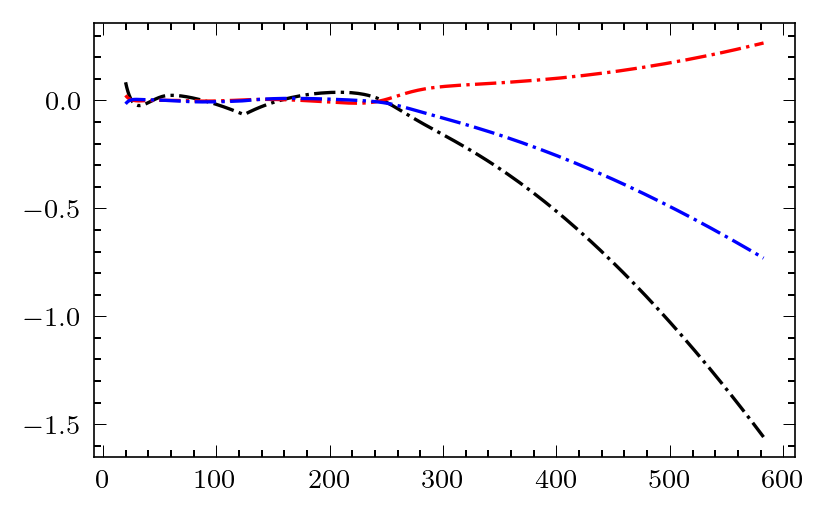

In [17]:
i=0

vals = norm/9/np.sum(singnorm) * s[i] * Vh[i, :] / weight / hgr["H1"]/1j
ang0 = -np.unwrap(np.real(vals))
# vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
# ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
plt.plot(obj.freqs,ang0, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])

i=1

vals = norm/9/np.sum(singnorm) * s[i] * Vh[i, :] / weight / hgr["H1"]/1j
ang1 = -np.unwrap(np.real(vals))
# vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
# ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
plt.plot(obj.freqs,ang1, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])


i=2

vals = norm/9/np.sum(singnorm) * s[i] * Vh[i, :] / weight / hgr["H1"]/1j
ang2 = -np.unwrap(np.real(vals))
# vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
# ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
plt.plot(obj.freqs,ang2, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])



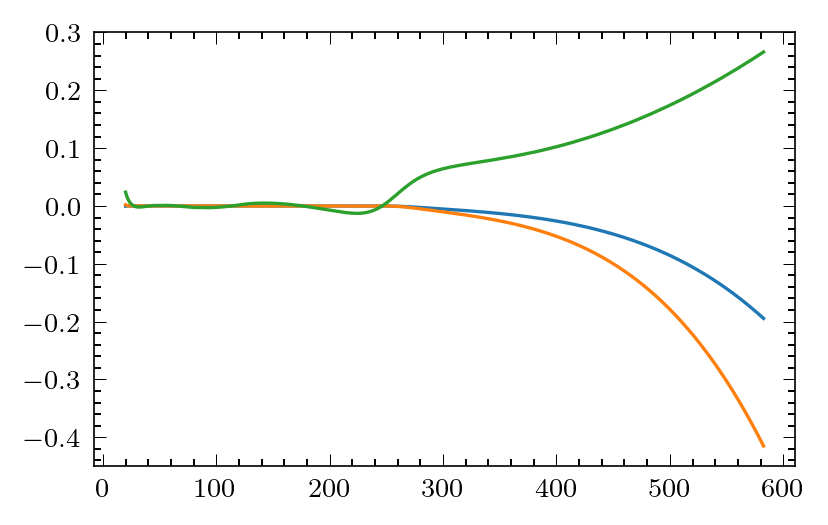

In [18]:
plt.plot(freqs, ang1*ang2)
plt.plot(freqs, ang1*ang0)
plt.plot(freqs, ang1)

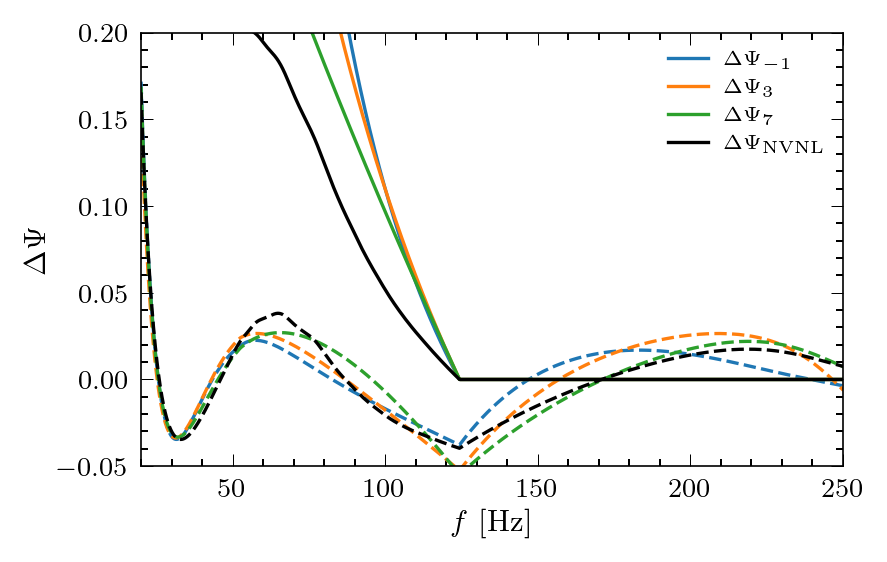

In [19]:
kkplt = [-1, 3, 7]

for k in kkplt:
    line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")
    plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j) , color = line.get_color(), ls = "--")

line, = plt.plot(obj.freqs,np.real(Dh_nvnl["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ \mathrm{{NVNL}} }}$", c = "k")
plt.plot(obj.freqs, np.real(dhperp_nvnl["H1"] / hgr["H1"]/1j) , color = line.get_color(), ls = "--")

plt.xlim(20, 250)
plt.ylim(-0.5,3)
plt.ylim(-0.05,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
# plt.ylim(-3/10,3)
plt.ylabel(r"$\Delta \Psi$") 
plt.ylim(-3/10,3)
# plt.savefig("psiperp-example1.pdf", bbox_inches='tight', pad_inches=0) 

plt.ylim(-0.05,0.2)
# plt.savefig("psiperp-example2.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

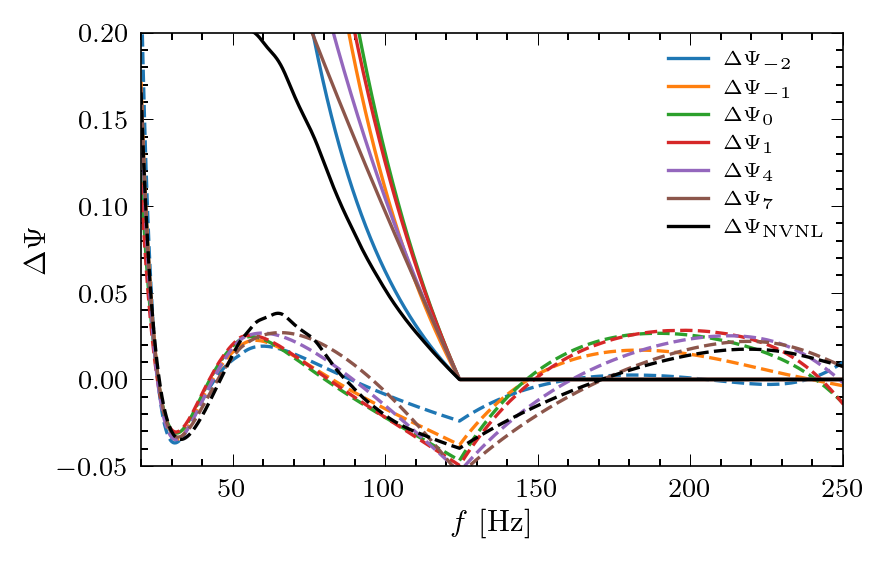

In [ ]:
kkplt = [-2, -1, 0,1,2,3,4,6, 7]
kkplt = [-2, -1, 0,1,4, 7]


for k in kkplt:
    line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")
    plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j) , color = line.get_color(), ls = "--")
    # plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j) ,  ls = "--")

line, = plt.plot(obj.freqs,np.real(Dh_nvnl["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ \mathrm{{NVNL}} }}$", c = "k")
plt.plot(obj.freqs, np.real(dhperp_nvnl["H1"] / hgr["H1"]/1j) , color = line.get_color(), ls = "--")

plt.xlim(20, 250)
plt.ylim(-0.5,3)
plt.ylim(-0.05,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
# plt.ylim(-3/10,3)
plt.ylabel(r"$\Delta \Psi$") 
plt.ylim(-3/10,3)
# plt.savefig("dpsiperp-example1.pdf", bbox_inches='tight', pad_inches=0) 

# plt.savefig("dpsiperp-example2.pdf", bbox_inches='tight', pad_inches=0) 

plt.ylim(-0.05,0.2)
# plt.savefig("dpsiperp-example3.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

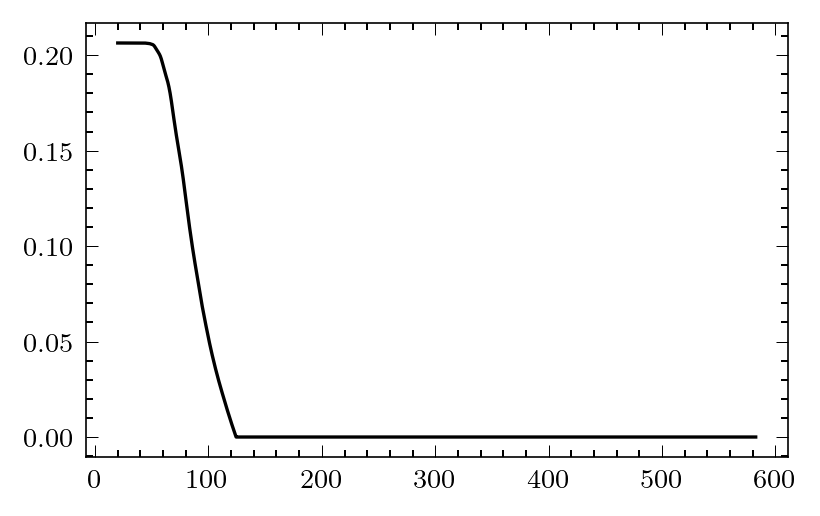

In [20]:
plt.plot(obj.freqs,np.real(Dh_nvnl["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ \mathrm{{NVNL}} }}$", c = "k")

In [6]:
rows = []
for key in obj.str2k:
    detectors = res[key]
    df = np.diff(obj.freqs)
    delta_f = np.empty_like(obj.freqs, dtype=float)
    delta_f[1:-1] = (df[:-1] + df[1:]) / 2.0
    delta_f[0] = df[0] / 2.0
    delta_f[-1] = df[-1] / 2.0
    weight = np.sqrt(2*delta_f/obj.psdO3)
    concatenated = np.concatenate([weight*detectors["H1"], weight*detectors["L1"], weight*detectors["V1"]])
    rows.append(concatenated)

result_array = np.vstack(rows)
U, s, Vh = np.linalg.svd(result_array, full_matrices=False)
sf = s
s

array([5.87290604e-01, 1.24045729e-01, 2.58568545e-02,
       1.92814718e-02, 2.70735867e-03, 2.30886798e-04,
       1.54001929e-05, 6.06092816e-07, 1.56851738e-08,
       2.53816397e-10])

In [ ]:
dhperp, Dh = compute_Dh_ppek_perp(1, dhgr, x, paramgr, cov)

for k in obj.k2str:
    dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
    res[obj.k2str[k]] = dhperp
    resDh[obj.k2str[k]] = Dh
    normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
    n1 = np.sum(normarr)**(1/2)

    normarr = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
    n2 = np.sum(normarr)**(1/2)
    print(f" {obj.k2str[k]} Dh: {np.real(n1):.2e}, Dhperp: {np.real(n2):.2e}")


 phi_-2 Dh: 1.00e+00, Dhperp: 2.67e-02
 phi_-1 Dh: 1.00e+00, Dhperp: 2.05e-02
 phi_0 Dh: 1.00e+00, Dhperp: 2.28e-02
 phi_1 Dh: 1.00e+00, Dhperp: 3.05e-02
 phi_2 Dh: 1.00e+00, Dhperp: 4.09e-02
 phi_3 Dh: 1.00e+00, Dhperp: 5.33e-02
 phi_4 Dh: 1.00e+00, Dhperp: 6.70e-02
 phi_5 Dh: 1.00e+00, Dhperp: 8.31e-01
 phi_6 Dh: 1.00e+00, Dhperp: 9.59e-02
 phi_7 Dh: 1.00e+00, Dhperp: 1.10e-01


In [ ]:
# Old code -----

dh = obj.get_dh_gr(x)
fi = obj.compute_fisher_raw(dhgr, x, paramgr)
cov = jnp.linalg.inv(fi)
dx_stat = np.diagonal(np.array(cov ))**(1/2)
idx_par = obj.idx_par.copy()
log_flag = obj.log_flag.copy()

Dh = {}
dx_bias = {}
k = 1
Dh = make_Dh_ppe_norm(k, x)
bias_ip = obj.compute_biasip_raw(dhgr, Dh, x, paramgr)
dx_bias = np.array(cov @ bias_ip)

for p in filter(log_flag.__getitem__, paramgr):
    i = idx_par[p]
    dx_bias[i] *= x[p]
    dx_stat[i] *= x[p]

dhpara, dhperp = {}, {}
for d in dets:
    dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in paramgr), jnp.zeros_like(freqs))
    dhperp[d] = Dh[d] - dhpara[d]

dpsi_perp = np.array((dhperp["H1"])/1j/hgr["H1"])


def compute_netsnr(data, psd, freqs, detectors):
    total_innprod = sum(lib.innprod(data[d], data[d], psd, freqs) for d in detectors)
    return np.real(np.sqrt(total_innprod))

snr        = compute_netsnr(hgr, obj.psdO3, obj.freqs, dets)
snr_dh     = compute_netsnr(Dh, obj.psdO3, obj.freqs, dets)
snr_dhperp = compute_netsnr(dhperp, obj.psdO3, obj.freqs, dets)
snr_dhpara = compute_netsnr(dhpara, obj.psdO3, obj.freqs, dets)

res = {'freqs' : freqs, 'dpsi_perp' : dpsi_perp, 'dh' : Dh["H1"], 'h' : hgr["H1"], 'dh_perp' : dhperp["H1"], 'dx_bias' : dx_bias, 'dx_stat' : dx_stat, 'snr':snr, 'snr_dh':snr_dh, 'snr_dhperp':snr_dhperp, 'snr_dhpara':snr_dhpara}

array([-2, -1,  0,  1,  2,  3,  4,  5,  6,  7])